# Evaluate models predictions (each model trained on different data - separated by players positions)
### Select best predicted squad and compare gained points with average points from specific gameweek

In [1]:
import pandas as pd
import tensorflow as tf
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import os

from src.data.data_loader import load_average_pts
from src.features.data_engineering import preprocess_seasons_data
from src.features.data_engineering import reverse_processing

from src.modeling.train_model import train_mlp_model
from src.modeling.predictions import merge_reversed_data_with_predictions
from src.modeling.evaluate_squad import squad_selection_without_constraints
from src.modeling.evaluate_squad import get_average_pts
from src.modeling.evaluate_squad import evaluate_selected_squad_without_constraints

In [2]:
average_pts = load_average_pts()

In [3]:
average_pts.head()

,GW,AVG_PTS_2016/17,AVG_PTS_2018/19,AVG_PTS_2021/22
0,1,44,53,69
1,2,56,59,56
2,3,40,48,54
3,4,41,43,57
4,5,47,46,55


#### Load training data

In [4]:
# load data by position
data_intermediate_path = os.path.dirname(os.getcwd()) + '\\data\\intermediate\\'

data_gk = pd.read_csv(data_intermediate_path + 'separate/gk.csv')
data_def = pd.read_csv(data_intermediate_path + 'separate/def.csv')
data_mid = pd.read_csv(data_intermediate_path + 'separate/mid.csv')
data_fwd = pd.read_csv(data_intermediate_path + 'separate/fwd.csv')

# Evaluate models trained on merged seasons data with historical rolling features and with data about next game opponent team

In [5]:
rolling_columns_gk = ['bonus', 'bps', 'clean_sheets', 'goals_conceded', 'influence', 'minutes',
                      'penalties_saved', 'saves', 'selected', 'player_team_score', 'opponent_team_score',
                      'total_points', 'transfers_in', 'transfers_out','value']

rolling_columns_def = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
                       'ict_index', 'influence', 'minutes', 'selected', 'player_team_score', 'opponent_team_score',
                       'threat', 'total_points', 'transfers_in', 'transfers_out', 'value', 'yellow_cards']

rolling_columns_mid = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
                       'ict_index', 'influence', 'minutes', 'selected', 'player_team_score', 'opponent_team_score',
                       'threat', 'total_points', 'transfers_in', 'transfers_out', 'value', 'yellow_cards']

rolling_columns_fwd = ['assists', 'bonus', 'bps', 'creativity', 'goals_scored', 'ict_index', 'influence',
                       'minutes', 'selected', 'player_team_score', 'opponent_team_score', 'threat',
                       'total_points', 'transfers_in', 'transfers_out', 'value', 'yellow_cards']

times = ['all', 6, 3]

test_subset_XL = (['2016-17', [4, 8, 9, 14, 18, 20, 21, 26, 32]], ['2018-19', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]], ['2021-22', [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]])

In [6]:
(x_train_gk, y_train_gk), (x_test_gk, y_test_gk), (x_train_target_gk, x_test_target_gk), x_scaler_gk = preprocess_seasons_data(data_gk, random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns_gk, rolling_times=times, opponent_team_stats=True)

(x_train_def, y_train_def), (x_test_def, y_test_def), (x_train_target_def, x_test_target_def), x_scaler_def = preprocess_seasons_data(data_def, random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns_def, rolling_times=times, opponent_team_stats=True)

(x_train_mid, y_train_mid), (x_test_mid, y_test_mid), (x_train_target_mid, x_test_target_mid), x_scaler_mid = preprocess_seasons_data(data_mid, random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns_mid, rolling_times=times, opponent_team_stats=True)

(x_train_fwd, y_train_fwd), (x_test_fwd, y_test_fwd), (x_train_target_fwd, x_test_target_fwd), x_scaler_fwd = preprocess_seasons_data(data_fwd, random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns_fwd, rolling_times=times, opponent_team_stats=True)

In [7]:
def train_baseline_mlp(x_train, y_train, x_test, x_scaler, x_test_target):
    model_mlp = tf.keras.models.Sequential()

    model_mlp.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))

    if len(x_train) > 50000:
        model_mlp.add(tf.keras.layers.Dense(units=256, activation='relu'))

    model_mlp.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model_mlp.add(tf.keras.layers.Dense(units=1, activation='linear'))

    model_mlp.compile(optimizer='adam', loss='mse')

    history = model_mlp.fit(x_train, y_train,
                            batch_size=16,
                            epochs=20,
                            validation_split=0.3,
                            verbose=0)

    x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)

    return model_mlp, x_test_reversed

In [8]:
def train_baseline_xgb(x_train, y_train, x_test, x_scaler, x_test_target):
    model_xgb = xgb.XGBRegressor()
    model_xgb.fit(x_train, y_train)

    x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)

    return model_xgb, x_test_reversed

In [9]:
# Make predictions on specific test subset using MLP and XGBoost models
model_mlp_gk, x_test_reversed_gk = train_baseline_mlp(x_train_gk, y_train_gk, x_test_gk, x_scaler_gk, x_test_target_gk)
predictions_mlp_gk = merge_reversed_data_with_predictions(model_mlp_gk, x_test_gk, y_test_gk, x_test_reversed_gk)

model_mlp_def, x_test_reversed_def = train_baseline_mlp(x_train_def, y_train_def, x_test_def, x_scaler_def, x_test_target_def)
predictions_mlp_def = merge_reversed_data_with_predictions(model_mlp_def, x_test_def, y_test_def, x_test_reversed_def)

model_mlp_mid, x_test_reversed_mid = train_baseline_mlp(x_train_mid, y_train_mid, x_test_mid, x_scaler_mid, x_test_target_mid)
predictions_mlp_mid = merge_reversed_data_with_predictions(model_mlp_mid, x_test_mid, y_test_mid, x_test_reversed_mid)

model_mlp_fwd, x_test_reversed_fwd = train_baseline_mlp(x_train_fwd, y_train_fwd, x_test_fwd, x_scaler_fwd, x_test_target_fwd)
predictions_mlp_fwd = merge_reversed_data_with_predictions(model_mlp_fwd, x_test_fwd, y_test_fwd, x_test_reversed_fwd)

# concatenate predictions_mlp_gk with predictions_mlp_def, predictions_mlp_mid and predictions_mlp_fwd
predictions_mlp_merged = pd.concat([predictions_mlp_gk, predictions_mlp_def, predictions_mlp_mid, predictions_mlp_fwd])

In [10]:
model_xgb_gk, x_test_reversed_gk = train_baseline_xgb(x_train_gk, y_train_gk, x_test_gk, x_scaler_gk, x_test_target_gk)
predictions_xgb_gk = merge_reversed_data_with_predictions(model_xgb_gk, x_test_gk, y_test_gk, x_test_reversed_gk)

model_xgb_def, x_test_reversed_def = train_baseline_xgb(x_train_def, y_train_def, x_test_def, x_scaler_def, x_test_target_def)
predictions_xgb_def = merge_reversed_data_with_predictions(model_xgb_def, x_test_def, y_test_def, x_test_reversed_def)

model_xgb_mid, x_test_reversed_mid = train_baseline_xgb(x_train_mid, y_train_mid, x_test_mid, x_scaler_mid, x_test_target_mid)
predictions_xgb_mid = merge_reversed_data_with_predictions(model_xgb_mid, x_test_mid, y_test_mid, x_test_reversed_mid)

model_xgb_fwd, x_test_reversed_fwd = train_baseline_xgb(x_train_fwd, y_train_fwd, x_test_fwd, x_scaler_fwd, x_test_target_fwd)
predictions_xgb_fwd = merge_reversed_data_with_predictions(model_xgb_fwd, x_test_fwd, y_test_fwd, x_test_reversed_fwd)

# concatenate predictions_xgb_gk with predictions_xgb_def, predictions_xgb_mid and predictions_xgb_fwd
predictions_xgb_merged = pd.concat([predictions_xgb_gk, predictions_xgb_def, predictions_xgb_mid, predictions_xgb_fwd])

In [11]:
# Get squad and evaluate it for both models
results_mlp, selected_squad_points_mlp, real_player_average_points_mlp, season_gameweeks_mlp = evaluate_selected_squad_without_constraints(predictions_mlp_merged, test_subset_XL, 'mlp_model-no_constraints_SPEARATE_test_subset_XL')
results_xgb, selected_squad_points_xgb, real_player_average_points_xgb, season_gameweeks_xgb = evaluate_selected_squad_without_constraints(predictions_xgb_merged, test_subset_XL, 'xgb_model-no_constraints_SPEARATE_test_subset_XL')

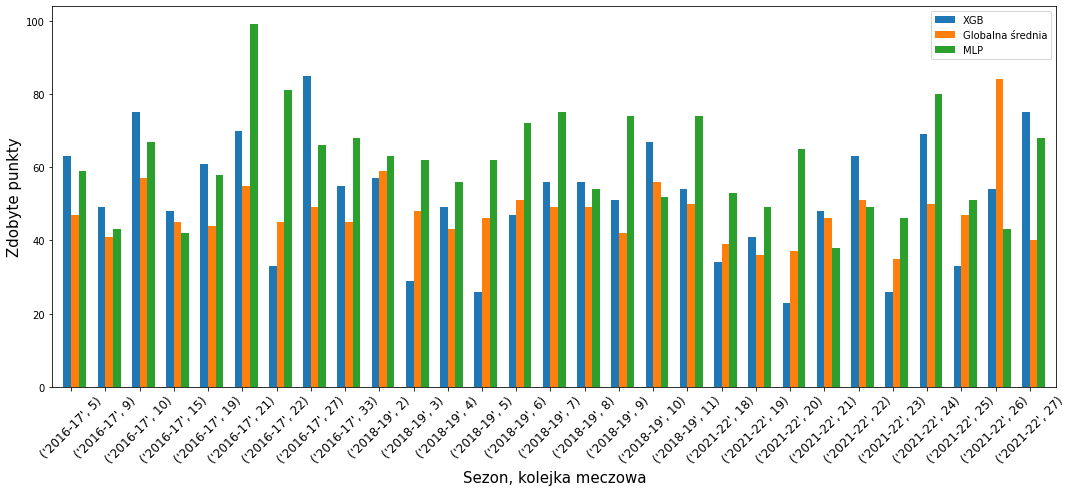

In [90]:
plt.figure(figsize=(18,7))

X_axis = np.arange(len(season_gameweeks_mlp))

plt.bar(X_axis*1.8 - 0.4, selected_squad_points_xgb, 0.4, label = 'XGB', align='edge')
plt.bar(X_axis*1.8, real_player_average_points_mlp, 0.4, label = 'Globalna średnia', align='edge')
plt.bar(X_axis*1.8 + 0.4, selected_squad_points_mlp, 0.4, label = 'MLP', align='edge')

# make less space on left and right side of the plot
plt.xlim(-1, 51.8)


plt.xticks(X_axis*1.8, season_gameweeks_mlp, rotation=45, fontsize=12)

plt.xlabel("Sezon, kolejka meczowa", fontsize=15)
plt.ylabel("Zdobyte punkty", fontsize=15)
#plt.title("Comparison of pts gained by squad selected by MLP model with points gained by squad selected by XGB model for big test subset")
plt.legend()

# save plot to file
plt.savefig('rysunek8.png' ,dpi=300, bbox_inches = "tight")

plt.show()

#### MLP model sum of points

In [13]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_mlp))
print('Sum of points gained by real players:', sum(real_player_average_points_mlp))
print('Difference:', sum(selected_squad_points_mlp) - sum(real_player_average_points_mlp), 'pts')

Sum of points gained by selected squad: 1769.0
Sum of points gained by real players: 1386
Difference: 383.0 pts


#### XGBoost model sum of points

In [14]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_xgb))
print('Sum of points gained by real players:', sum(real_player_average_points_xgb))
print('Difference:', sum(selected_squad_points_xgb) - sum(real_player_average_points_xgb), 'pts')

Sum of points gained by selected squad: 1497.0
Sum of points gained by real players: 1386
Difference: 111.0 pts


### Conclustion #1
MLP model seems to gain much more points than XGBoost model when 4 different models are trained with data separated by player position. It's strange for me, because I was expecting that XGB model will be better, when datasets are smaller. Comparing to the models trained with all data together, MLP model seems to have similar performance, but XGB model seems to be worse. Now I will try to train models separated on GK data and Field_players data.

## Train two separate models (GK and Field_players)

In [127]:
# load data by position
data_intermediate_path = os.path.dirname(os.getcwd()) + '\\data\\intermediate\\'

data_gk = pd.read_csv(data_intermediate_path + 'separate/gk.csv')
data_field = pd.read_csv(data_intermediate_path + 'separate/field.csv')

In [128]:
rolling_columns_field = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored',
                       'ict_index', 'influence', 'minutes', 'selected', 'player_team_score', 'opponent_team_score',
                       'threat', 'total_points', 'transfers_in', 'transfers_out', 'value', 'yellow_cards']

In [129]:
(x_train_gk, y_train_gk), (x_test_gk, y_test_gk), (x_train_target_gk, x_test_target_gk), x_scaler_gk = preprocess_seasons_data(data_gk, random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns_gk, rolling_times=times, opponent_team_stats=True)

(x_train_field, y_train_field), (x_test_field, y_test_field), (x_train_target_field, x_test_target_field), x_scaler_field = preprocess_seasons_data(data_field, random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns_field, rolling_times=times, opponent_team_stats=True)

In [130]:
# Make predictions on specific test subset using MLP and XGBoost models
model_mlp_gk, x_test_reversed_gk = train_baseline_mlp(x_train_gk, y_train_gk, x_test_gk, x_scaler_gk, x_test_target_gk)
predictions_mlp_gk = merge_reversed_data_with_predictions(model_mlp_gk, x_test_gk, y_test_gk, x_test_reversed_gk)

model_mlp_field, x_test_reversed_field = train_baseline_mlp(x_train_field, y_train_field, x_test_field, x_scaler_field, x_test_target_field)
predictions_mlp_field = merge_reversed_data_with_predictions(model_mlp_field, x_test_field, y_test_field, x_test_reversed_field)

# concatenate predictions_mlp_gk with predictions_mlp_def, predictions_mlp_mid and predictions_mlp_fwd
predictions_mlp_merged_field = pd.concat([predictions_mlp_gk, predictions_mlp_field])

In [131]:
model_xgb_gk, x_test_reversed_gk = train_baseline_xgb(x_train_gk, y_train_gk, x_test_gk, x_scaler_gk, x_test_target_gk)
predictions_xgb_gk = merge_reversed_data_with_predictions(model_xgb_gk, x_test_gk, y_test_gk, x_test_reversed_gk)

model_xgb_field, x_test_reversed_field = train_baseline_xgb(x_train_field, y_train_field, x_test_field, x_scaler_field, x_test_target_field)
predictions_xgb_field = merge_reversed_data_with_predictions(model_xgb_field, x_test_field, y_test_field, x_test_reversed_field)

# concatenate predictions_xgb_gk with predictions_xgb_def, predictions_xgb_mid and predictions_xgb_fwd
predictions_xgb_merged_field = pd.concat([predictions_xgb_gk, predictions_xgb_field])

In [132]:
# Get squad and evaluate it for both models
results_mlp_field, selected_squad_points_mlp_field, real_player_average_points_mlp_field, season_gameweeks_mlp_field = evaluate_selected_squad_without_constraints(predictions_mlp_merged_field, test_subset_XL, 'mlp_model-no_constraints_FIELD_test_subset_XL')
results_xgb_field, selected_squad_points_xgb_field, real_player_average_points_xgb_field, season_gameweeks_xgb_field = evaluate_selected_squad_without_constraints(predictions_xgb_merged_field, test_subset_XL, 'xgb_model-no_constraints_FIELD_test_subset_XL')

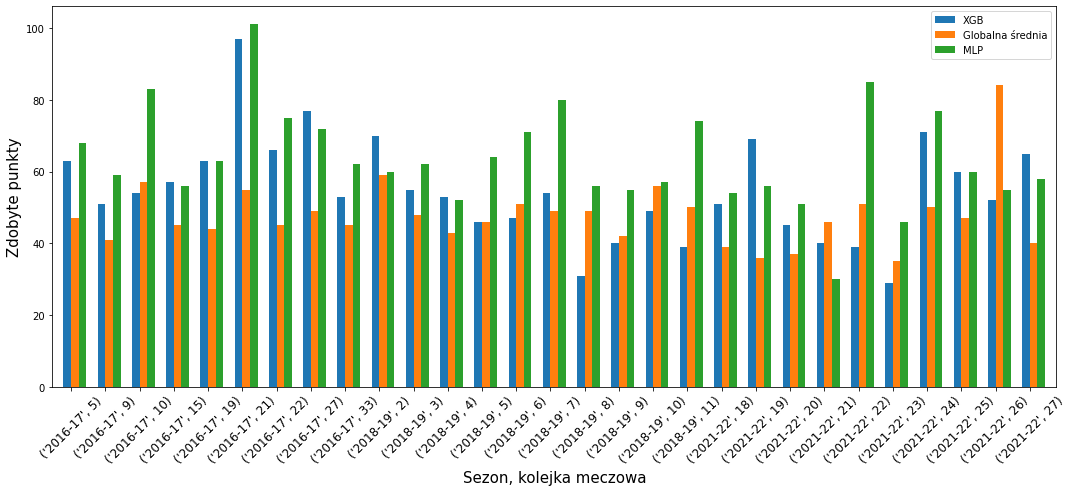

In [136]:
plt.figure(figsize=(18,7))

X_axis = np.arange(len(season_gameweeks_mlp))

plt.bar(X_axis*1.8 - 0.4, selected_squad_points_xgb_field, 0.4, label = 'XGB', align='edge')
plt.bar(X_axis*1.8, real_player_average_points_mlp_field, 0.4, label = 'Globalna średnia', align='edge')
plt.bar(X_axis*1.8 + 0.4, selected_squad_points_mlp_field, 0.4, label = 'MLP', align='edge')

# make less space on left and right side of the plot
plt.xlim(-1, 51.8)


plt.xticks(X_axis*1.8, season_gameweeks_mlp, rotation=45, fontsize=12)

plt.xlabel("Sezon, kolejka meczowa", fontsize=15)
plt.ylabel("Zdobyte punkty", fontsize=15)
#plt.title("Comparison of pts gained by squad selected by MLP model with points gained by squad selected by XGB model for big test subset")
plt.legend()

# save plot to file
plt.savefig('rysunek9.png' ,dpi=300, bbox_inches = "tight")

plt.show()

#### MLP model sum of points

In [134]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_mlp_field))
print('Sum of points gained by real players:', sum(real_player_average_points_mlp))
print('Difference:', sum(selected_squad_points_mlp_field) - sum(real_player_average_points_mlp), 'pts')

Sum of points gained by selected squad: 1842.0
Sum of points gained by real players: 1386
Difference: 456.0 pts


#### XGBoost model sum of points

In [135]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_xgb_field))
print('Sum of points gained by real players:', sum(real_player_average_points_xgb))
print('Difference:', sum(selected_squad_points_xgb_field) - sum(real_player_average_points_xgb), 'pts')

Sum of points gained by selected squad: 1586.0
Sum of points gained by real players: 1386
Difference: 200.0 pts


In [24]:
results_mlp_field

[(                  name  total_points_next_gameweek  value
  0    Kasper_Schmeichel                         0.0   50.0
  1     Shkodran_Mustafi                         2.0   60.0
  2           Scott_Dann                         8.0   55.0
  3      Héctor_Bellerín                         2.0   65.0
  4       Alexis_Sánchez                        20.0  110.0
  5   Manuel_Agudo Durán                         3.0   90.0
  6           Mesut_Özil                         2.0   96.0
  7          Eden_Hazard                         2.0  103.0
  8          David_Silva                         0.0   89.0
  9          Jamie_Vardy                         6.0   99.0
  10          Harry_Kane                         9.0  109.0,
  54.0),
 (                              name  total_points_next_gameweek  value
  0   Adrián_San Miguel del Castillo                         6.0   50.0
  1                  Héctor_Bellerín                         7.0   65.0
  2                  Nathaniel_Clyne                  